# Skin Cancer Training using MONAI

## Overview

HAM10000 ("Human Against Machine with 10000 training images") is a popular data set of dermatoscopic images hosted by [Harvard Dataverse](https://dataverse.harvard.edu/) from different populations.  It consists of 10015 images consisting of several diagnositic categories including: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

In this example we will demonstrate how to integrate the [MONAI](http://monai.io) framework into Amazon SageMaker using Pytorch and give example code of MONAI pre-processing transforms that can assist with imbalanced datasets and image transformations.  We will also show the code to invoke MONAI neural network architectures such as Densenet for image classification and explore structure of Pytorch code to train and serve the model within SageMaker.  Additionally, we will cover the SageMaker API calls to launch and manage the compute infrastructure for both model training and hosting for inference using the HAM10000 data set.

For more information about the PyTorch in SageMaker, please visit [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers) and [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk) github repositories.

---

## Setup

This notebook was created and tested on an ml.t2.medium notebook instance with 100 GB of EBS and conda_pytorch_p36 kernel.

Let's get started by creating a S3 bucket and uploading the HAM10000 dataset to the bucket.

<ol>
<li>Create an S3 bucket in the same account as the Sagemaker notebook instance.
<li>Download the skin cancer dataset at <a href="https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T">HAM10000</a>.
<li>Select "Access Dataset" in top right, and select "Original Format Zip".
<li>Upload the dataset to the S3 bucket created in step 1.
<li>Update the set.env file located in the current directory with the S3 location of the dataverse_files.zip.
</ol>

The code below will install MONAI framework and dependent packages and setup environment variables.

In [1]:
# Copyright 2020 Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: MIT-0

!pip install -r source/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.4/298.4 kB 5.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.1 MB/s eta 0:00:0000:01
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [22]:
import os
from pathlib import Path
from dotenv import load_dotenv
env_path = Path('.') / 'set.env'
load_dotenv(dotenv_path=env_path)

skin_cancer_bucket=os.environ.get('SKIN_CANCER_BUCKET')
skin_cancer_bucket_path=os.environ.get('SKIN_CANCER_BUCKET_PATH')
skin_cancer_files=os.environ.get('SKIN_CANCER_FILES')
skin_cancer_files_ext=os.environ.get('SKIN_CANCER_FILES_EXT')
base_dir = os.environ.get('BASE_DIR')

print('Skin Cancer Bucket: '+skin_cancer_bucket)
print('Skin Cancer Bucket Prefix: '+skin_cancer_bucket_path)
print('Skin Cancer Files: '+skin_cancer_files)
print('Skin Cancer Files Ext: '+skin_cancer_files_ext)
print('Base Dir: '+base_dir)

Skin Cancer Bucket: ecc-project-dataset
Skin Cancer Bucket Prefix: Skin-Cancer-Dectection
Skin Cancer Files: dataverse_files
Skin Cancer Files Ext: dataverse_files.zip
Base Dir: ../


In [23]:
!python -m pip install python-dotenv

## HAM10000 Data Transformation

The transform_data.ipynb will download the dataverse_files.zip and perform transformations to build directories by class for training and validation sets from the meta-data.  It will also augment the data to create a more balanced data set across the classes for training.  The script will upload the transformed dataset HAM10000.tar.gz to the same S3 bucket identifed in set.env for model training.

Download training data set from ecc-project-dataset
Uncompress data set for transformation
Create training and validation dir under HAM10000
Remove duplicates
Organize Images by Skin Cancer Class
Images by Class
nv: 5954
mel: 1074
bkl: 1024
bcc: 484
akiec: 301
vasc: 131
df: 109
Augment Images By Class
Images by Class After Augmentation
nv: 5954
mel: 5370
bkl: 5120
bcc: 5324
akiec: 5117
vasc: 5109
df: 5014


Matplotlib is building the font cache; this may take a moment.



Sample of Training images


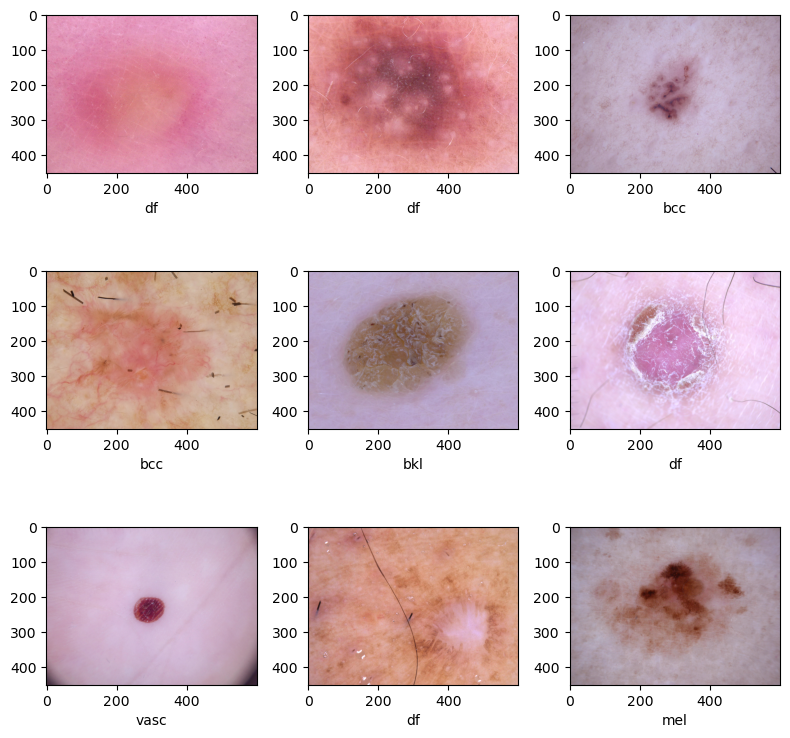


Total image count: 37008
Image dimensions: 600 x 450
Label names: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Label counts: [5117, 5324, 5120, 5014, 5370, 5954, 5109]

Compressing transformed HAM10000 data set.
tar: Removing leading `../' from member names
Training dataset transformation complete.


In [24]:
%run source/transform_data.ipynb

## Data

### Create Sagemaker session and S3 location for transformed HAM10000 dataset

In [25]:
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

inputs = sagemaker_session.upload_data(path=base_dir+'HAM10000.tar.gz', bucket=skin_cancer_bucket, key_prefix=skin_cancer_bucket_path)
print('input spec (in this case, just an S3 path): {}'.format(inputs))

input spec (in this case, just an S3 path): s3://ecc-project-dataset/Skin-Cancer-Dectection/HAM10000.tar.gz


In [6]:
pip install sagemaker==2.182.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 8.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Using cached smdebug_rulesconfig-1.0.1-py2.py3-none-any.whl (20 kB)
  Created wheel for sagemaker: filename=sagemaker-2.182.0-py2.py3-none-any.whl size=1185307 sha256=019b8f660c24bcdee4a8dceb05b0ff62b463e2cd79e8a66c3f0ae32e08e092e9
  Stored in directory: /home/ec2-user/.cache/pip/wheels/07/0c/af/ead4148322733a12bce80af91e36ecb67da78cc84fc01555bf
Successfully built sagemaker
  Attempting uninstall: smdebug_rulesconfig
    Found existing installation: smdebug-rulesconfig 0.1.5
    Uninstalling smdebug-rulesconfig-0.1.5:
      Successfully uninstalled smdebug-rulesconfig-0.1.5
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.18.0
    Uninstalling sagemaker-2.18.0:
      Successfully uninstalled sagemaker-2.18.0
Note: you may need to restart the kernel to use updated packages.


## Train Model
### Training

The ```monai_skin_cancer.py``` script provides all the code we need for training and hosting a SageMaker model (model_fn function to load a model). The training script is very similar to a training script you might run outside of SageMaker, but you can access useful properties about the training environment through various environment variables, such as:

* SM_MODEL_DIR: A string representing the path to the directory to write model artifacts to. These artifacts are uploaded to S3 for model hosting.
* SM_NUM_GPUS: The number of gpus available in the current container.
* SM_CURRENT_HOST: The name of the current container on the container network.
* SM_HOSTS: JSON encoded list containing all the hosts .
Supposing one input channel, 'training', was used in the call to the PyTorch estimator's fit() method, the following will be set, following the format SM_CHANNEL_[channel_name]:

* SM_CHANNEL_TRAINING: A string representing the path to the directory containing data in the 'training' channel.
For more information about training environment variables, please visit [SageMaker Containers](https://github.com/aws/sagemaker-containers).

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to model_dir so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an argparse.ArgumentParser instance.

Because the SageMaker imports the training script, you should put your training code in a main guard (''if __name__=='__main__':'') if you are using the same script to host your model as we do in this example, so that SageMaker does not inadvertently run your training code at the wrong point in execution.

MONAI includes deep neural networks such as UNet, DenseNet, GAN and others and provides sliding window inferences for large medical image volumes.  In the skin cancer image classification model, we train the MONAI DenseNet model on the skin cancer images for thirty epochs while measuring loss.

In [26]:
!pygmentize source/monai_skin_cancer.py

# Copyright 2020 Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: MIT-0

import argparse
import json
import logging
import os
import sys
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchtext
import numpy as np
from PIL import Image
from monai.config import print_config
from monai.transforms import \
    Compose, LoadPNG, Resize, AsChannelFirst, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom
from monai.networks.nets import densenet121
from monai.metrics import compute_roc_auc
from skin_cancer_dataset import SkinCancerDataset


logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


def _get_train_data_loader(batch_size, trainX, trainY, is_distributed, **kwargs):

## Run training in SageMaker

The `PyTorch` class allows us to run our training function as a training job on SageMaker infrastructure.  We need to configure it with our training script, an IAM role, the number of training instances, the training instance type, and hyperparameters.  In this case we are going to run our training job on ```ml.p3.8xlarge``` instance.  But this example can be ran on one or multiple, cpu or gpu instances ([full list of available instances](https://aws.amazon.com/sagemaker/pricing/instance-types/)).  The hyperparameters parameter is a dict of values that will be passed to your training script -- you can see how to access these values in the ```monai_skin_cancer.py``` script above.

In [29]:
from sagemaker.pytorch import PyTorch
estimator = PyTorch(entry_point='monai_skin_cancer.py',
                    source_dir='source',
                    role=role,
                    framework_version='1.5.0',
                    py_version='py3',
                    instance_count=1,
                    instance_type='ml.m4.4xlarge',
                    hyperparameters={
                        'backend': 'gloo',
                        'epochs': 10
                    })

NOTEBOOK_METADATA_FILE detected but failed to get valid domain and user from it.


After we've constructed our PyTorch object, we can fit it using the HAM10000 dataset we uploaded to S3. SageMaker will download the data to the local filesystem, so our training script can simply read the data from disk.

In [ ]:
estimator.fit({'train': inputs})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-12-04-13-09-35-349


Using provided s3_resource
2023-12-04 13:09:35 Starting - Starting the training job...
2023-12-04 13:09:50 Starting - Preparing the instances for training.........
2023-12-04 13:11:20 Downloading - Downloading input data.....................................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-12-04 13:17:42,865 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-12-04 13:17:42,879 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-12-04 13:17:42,891 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-12-04 13:17:42,894 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-12-04 13:17:43,111 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.6 -m pip install -r requirements.txt
  Attempting uninstall: nump

## HOST Model
### Create real-time endpoint

After training, we use the ``PyTorch`` estimator object to build and deploy a PyTorchPredictor. This creates a Sagemaker Endpoint -- a hosted prediction service that we can use to perform inference.

As mentioned above we have implementation of `model_fn` in the monai_skin_cancer.py script that is required. We are going to use default implementations of `input_fn`, `predict_fn`, `output_fn` and `transform_fm` defined in [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers).

The arguments to the deploy function allow us to set the number and type of instances that will be used for the Endpoint. These do not need to be the same as the values we used for the training job. For example, you can train a model on a set of GPU-based instances, and then deploy the Endpoint to a fleet of CPU-based instances, but you need to make sure that you return or save your model as a cpu model similar to what we did in monai_skin_cancer.py. Here we will deploy the model to a single ```ml.m5.xlarge``` instance.

In [ ]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-2-087733582531/pytorch-training-2023-12-04-13-09-35-349/output/model.tar.gz), script artifact (s3://sagemaker-us-east-2-087733582531/pytorch-training-2023-12-04-13-09-35-349/source/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-2-087733582531/pytorch-training-2023-12-04-16-41-34-400/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-training-2023-12-04-16-41-34-400
INFO:sagemaker:Creating endpoint-config with name pytorch-training-2023-12-04-16-41-34-400
INFO:sagemaker:Creating endpoint with name pytorch-training-2023-12-04-16-41-34-400


----!

### Load Validation Images for Inference 

In [ ]:
from PIL import Image

print('Load Test Images for Inference')
val_dir = os.path.join(base_dir, 'HAM10000/val_dir')
class_names = sorted([x for x in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, x))])
num_class = len(class_names)
image_files = [[os.path.join(val_dir, class_name, x)
                for x in os.listdir(os.path.join(val_dir, class_name))[:1]] 
               for class_name in class_names]
image_file_list = []
image_label_list = []

for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
        
num_total = len(image_label_list)
image_width, image_height = Image.open(image_file_list[0]).size

Load Test Images for Inference


### MONAI Transform Image using Compose and Skin Cancer Dataset

MONAI has transforms that support both Dictionary and Array format and are specialized for the high-dimensionality of medical images.  The transforms include several categories such as Crop & Pad, Intensity, IO, Post-processing, Spatial, and Utilities.  In the following excerpt, the Compose class chains a series of image transforms together and returns a single tensor of the image.

In [42]:
from monai.transforms import Compose, Resize, Transpose, ScaleIntensity, ToTensor, LoadImage

val_transforms = Compose([
    LoadImage(image_only=True, dtype='float32'),
    Transpose((2, 0, 1)), 
    Resize((256, 256)),
    ScaleIntensity(),
    ToTensor()
])

val_ds = SkinCancerDataset(image_file_list, image_label_list, val_transforms)


In [34]:
pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


### Evaluate
We can now use the predictor to perform a real-time inference to classify skin cancer images.

In [44]:
# Define val_loader
val_loader = DataLoader(val_ds, batch_size=1, num_workers=1)

# Inference code
print('Sample Inference Results By Class:')
for i, val_data in enumerate(val_loader):
    response = predictor.predict(val_data[0])
    actual_label = val_data[1]
    pred = torch.nn.functional.softmax(torch.tensor(response), dim=1)
    top_p, top_class = torch.topk(pred, 1)
    print('actual class: ' + class_names[actual_label.numpy()[0]])
    print('predicted class: ' + class_names[top_class])
    print('predicted class probability: ' + str(round(top_p.item(), 2)))
    print()

Sample Inference Results By Class:
actual class: akiec
predicted class: vasc
predicted class probability: 0.8

actual class: bcc
predicted class: vasc
predicted class probability: 0.98

actual class: bkl
predicted class: nv
predicted class probability: 0.69

actual class: df
predicted class: nv
predicted class probability: 0.65

actual class: mel
predicted class: nv
predicted class probability: 0.5

actual class: nv
predicted class: nv
predicted class probability: 0.9

actual class: vasc
predicted class: vasc
predicted class probability: 0.76

